# Integration, Cointegration, and Stationarity
Initially by Delaney Granizo-Mackenzie and Maxwell Margenot

In [86]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

# Stationarity/Non-Stationarity
A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time. As an example, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

In [87]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

## Series A
### Example of a stationary time series

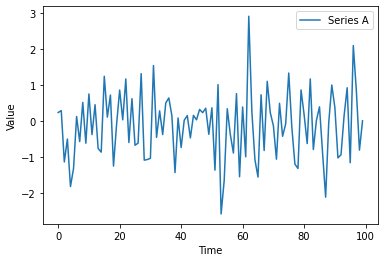

In [88]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T), dtype=np.float64)
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

## Series B
### Example of a non-stationary time series

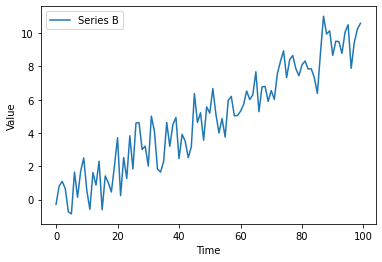

In [89]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T), dtype=np.float64)
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)

plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B']);

## Why Non-Stationarity is Dangerous
Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. Also, if you naively use certain statistics on a non-stationary data set, you will get garbage results. As an example, let's take an average through our non-stationary  B.

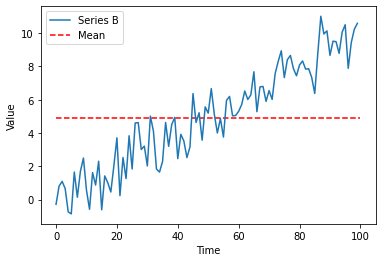

In [90]:
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean']);

The computed mean will show the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can screw with analysis, much more subtle problems can arise in practice.

## Testing for Stationarity
Now we want to check for stationarity using a statistical test.
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [91]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print(f'p-value = {pvalue} The series {X.name} is likely stationary.')
        return True
    else:
        print(f'p-value = {pvalue} The series {X.name} is likely non-stationary.')
        return False

In [92]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 3.7831214058147553e-10 The series A is likely stationary.
p-value = 0.8684477502063214 The series B is likely non-stationary.


Sure enough, the changing mean of the series makes it non-stationary. Let's try an example that might be a little more subtle.

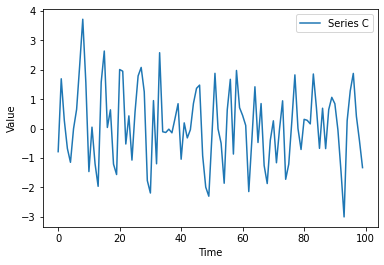

In [93]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T), dtype=np.float64)
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

In [94]:
check_for_stationarity(C);

p-value = 2.0576360199604605e-13 The series C is likely stationary.


## Order of Integration

### Moving Average Representation

An important concept in time series analysis is moving average representation. We will discuss this briefly here, but a more complete explanation is available in the [AR, MA](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%202.ipynb) and [ARMA Models](https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%203.ipynb) sheets. Also check Wikipedia as listed below.

This representation expresses any time series $Y_t$ as 

$$Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t$$

* $\epsilon$ is the residuals or errors - a stochastic white noise process
* $b_j$ are the moving average weights of residuals
* $\eta$ is a deterministic series

$\eta$ is deterministic (such as a sine wave),something we could perfectly model it. The difference between predictions from this model ($\eta$) and actual observations leads to residuals($\epsilon$). The residuals are stochastic and there to simulate new information occuring over time. 

Specifically, $\epsilon_t = \hat Y_t - Y_t$ where $\hat Y_t$ is the in the optimal forecast of $Y_t$(actual observed value) using only information from time before $t$. In other words, the best prediction you can make at time $t-1$ cannot account for the randomness in $\epsilon$.

Each $b_j$ just says how much previous values of $\epsilon$ influence $Y_t$.


### Back to Order of Integration

We will note integration order-i as $I(i)$.

A time series is said to be $I(0)$ if the following condition holds in a moving average representation. In simpler terms, the autocorrelation of the series decays to 0 sufficiently quickly.

$$\sum_{k=0}^\infty |b_k|^2 < \infty$$

This property turns out to be true of all stationary series since autocorrelation is 0, but by itself is not enough for stationarity to hold. This means that stationarity implies $I(0)$, but $I(0)$ does not imply stationarity. For more on orders of integration, please see the following links.

https://en.wikipedia.org/wiki/Order_of_integration

https://en.wikipedia.org/wiki/Wold%27s_theorem

### Testing for $I(0)$

In practice testing whether the sum of the autocorrelations is finite may not be possible. It is possible in a mathematical derivation, but when we have a finite set of data and a finite number of estimated autocorrelations, the sum will always be finite. Given this difficulty, tests for $I(0)$ rely on stationarity implying the property. If we find that a series is stationary, then it must also be $I(0)$.

Let's take our original stationary series A. Because A is stationary, we know it's also $I(0)$.

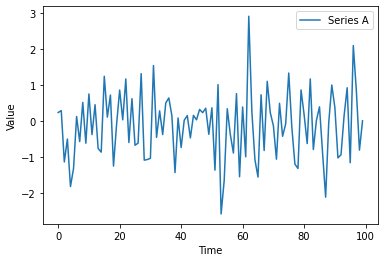

In [95]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])
plt.show()

### Building Up Orders of Integration

If one takes an $I(0)$ series and cumulatively sums it (discrete integration), the new series will be $I(1)$. Notice how this is related to the calculus concept of integration. The same relation applies in general, to get $I(n)$ take an $I(0)$ series and iteratively take the cumulative sum $n$ times.

Now let's make an $I(1)$ series by taking the cumulative sum of A.

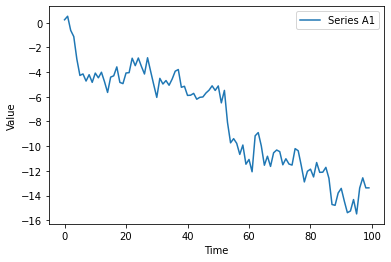

In [96]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1'])
plt.show()

Now let's make one $I(2)$ by taking the cumlulative sum again.

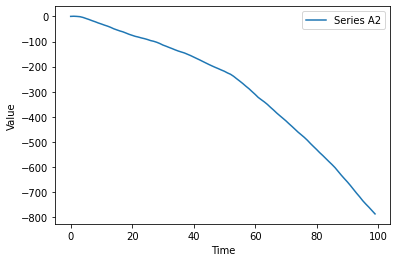

In [97]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

### Breaking Down Orders of Integration
Conversely, to find the order of integration of a given series, we perform the inverse of a cumulative sum, which is the $\Delta$ or itemwise difference function. Specifically

$$(1 - L)X_t = X_t - X_{t-1} = \Delta X$$
$$(1 - L)^d X_t$$
 
In this case $L$ is the lag operator. Sometimes also written as $B$ for 'backshift'. $L$ fetches the second to last elements in a time series, and $L^k$ fetches the k-th to last elements. So

$$LX_t=X_{t−1}$$
 
and

$$(1−L)X_t=X_t−X_{t−1}$$
 
A series $Y_t$ is $I(1)$ if the $Y_t − Y_{t−1}$ is $I(0)$. In other words, if you take an $I(0)$ series and cumulatively sum it, you should get an $I(1)$ series.

### Important Take-Away
Once all the math has settled, remember that any stationary series is  $I(0)$

## Real Data

Let's try this out on some real pricing data.
Note: the original data source does not work any more. So I just change it to some HK-listed stocks instead!

In [98]:
import pandas_datareader.data as web
import datetime as dt

df = web.DataReader('0700.hk', 'yahoo', dt.date(2015, 1, 1), dt.date(2020, 12, 31))
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,113.599998,111.300003,113.599998,112.800003,10862542.0,111.096741
2015-01-05,115.300003,112.800003,113.500000,113.500000,21808993.0,111.786163
2015-01-06,120.500000,113.599998,114.000000,120.000000,43678255.0,118.188011
2015-01-07,124.500000,122.599998,123.500000,124.400002,40863410.0,122.521576
2015-01-08,127.800003,125.599998,127.500000,127.300003,35638986.0,125.377777
...,...,...,...,...,...,...
2020-12-24,557.500000,557.500000,557.500000,557.500000,0.0,557.500000
2020-12-28,542.000000,519.000000,539.500000,519.000000,60559725.0,519.000000
2020-12-29,539.000000,526.000000,530.000000,530.500000,36250049.0,530.500000


In [99]:
df_sr = df['Adj Close'].diff()[1:,]
df_lr = np.log(df['Adj Close']).diff()[1:,]

#X = df['Adj Close'].copy()
df_lr

Date
2015-01-05    0.006186
2015-01-06    0.055689
2015-01-07    0.036010
2015-01-08    0.023044
2015-01-09   -0.000786
                ...   
2020-12-24   -0.023927
2020-12-28   -0.071559
2020-12-29    0.021916
2020-12-30    0.053224
2020-12-31    0.011551
Name: Adj Close, Length: 1480, dtype: float64

In [100]:
check_for_stationarity(df['Adj Close']);
check_for_stationarity(df_sr);
check_for_stationarity(df_lr);

p-value = 0.9133859506741251 The series Adj Close is likely non-stationary.
p-value = 1.8129855136996665e-12 The series Adj Close is likely stationary.
p-value = 0.0 The series Adj Close is likely stationary.


Let's take a look, certainly has the warning signs of a non-stationary series.

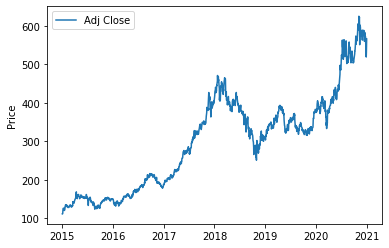

In [101]:
plt.plot(df.index, df['Adj Close'])
plt.ylabel('Price')
plt.legend([df['Adj Close'].name]);

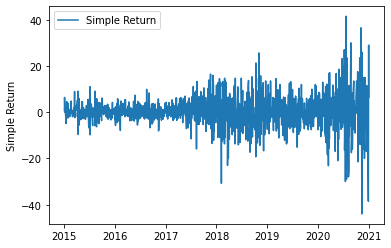

In [102]:
plt.plot(df_sr.index, df_sr.values)
plt.ylabel('Simple Return')
plt.legend(['Simple Return']);

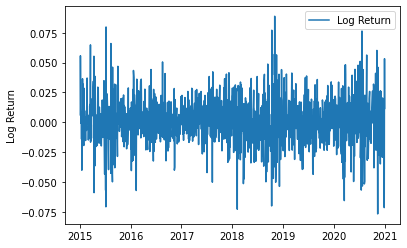

In [103]:
plt.plot(df_lr.index, df_lr.values)
plt.ylabel('Log Return')
plt.legend(['Log Return']);

### Cointegration

Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.

A linear combination of the time series ($X_1$, $X_2$, $\dots$, $X_k$) is a new time series $Y$ constructed as follows for any set of real numbers $b_1 \dots b_k$

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated.

For example, $X_1$, $X_2$, and $X_3$ are all $I(1)$, and $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ is $I(0)$. In this case the time series are cointegrated.

#### Intuition

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices $b_1A_1 + b_2A_2$ is noise, we can bet on the relationship $b_1A_1 + b_2A_2$ mean reverting and place trades accordingly. See the Pairs Trading notebook for more information.

### Testing for Cointegration

There are a bunch of ways to test for cointegration. This [wikipedia article](https://en.wikipedia.org/wiki/Cointegration) describes some. In general we're just trying to solve for the coefficients $b_1, \dots b_k$ that will produce an $I(0)$ linear combination. If our best guess for these coefficients does not pass a stationarity check, then we reject the hypothesis that the set is cointegrated. This will lead to risk of Type II errors (false negatives), as we will not exhaustively test for stationarity on all coefficent combinations. However Type II errors are generally okay here, as they are safe and do not lead to us making any wrong forecasts.

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

$$X_2 = \alpha + \beta X_1 + \epsilon$$

The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. The combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be stationary.

## Cointegration is HARD to find!

Pepsi and Coca-cola is the pair I can think of and it works.

In [104]:
df_pep = web.DataReader('PEP', 'yahoo', dt.date(2015, 1, 1), dt.date(2020, 12, 31))
df_ko = web.DataReader('KO', 'yahoo', dt.date(2015, 1, 1), dt.date(2020, 12, 31))
df_ko

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,42.939999,42.220001,42.919998,42.220001,9369500.0,34.397274
2015-01-02,42.400002,41.799999,42.259998,42.139999,9921100.0,34.332104
2015-01-05,42.970001,42.080002,42.689999,42.139999,26292600.0,34.332104
2015-01-06,42.939999,42.240002,42.410000,42.459999,16897500.0,34.592823
2015-01-07,43.110001,42.580002,42.799999,42.990002,13412300.0,35.024609
...,...,...,...,...,...,...
2020-12-24,53.549999,53.020000,53.020000,53.439999,3265500.0,52.998867
2020-12-28,54.439999,53.730000,53.849998,54.160000,9020500.0,53.712925
2020-12-29,54.490002,54.020000,54.450001,54.130001,8320600.0,53.683174


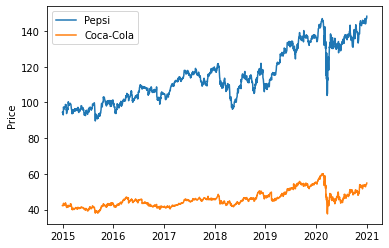

In [105]:
plt.plot(df_pep.index, df_pep['Close'])
plt.plot(df_ko.index, df_ko['Close'])
plt.ylabel('Price')
plt.legend(['Pepsi', 'Coca-Cola']);

In [106]:
#df_pep['Close'].values

In [107]:
import statsmodels.formula.api as smf

df_train = pd.DataFrame()
df_train['X'] = df_pep['Close']
df_train['y'] = df_ko['Close']
model = smf.ols(formula = 'y ~ X',
                data = df_train).fit()
# This formula is given as domain knowledge
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     4589.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:36:16   Log-Likelihood:                -3321.1
No. Observations:                1512   AIC:                             6646.
Df Residuals:                    1510   BIC:                             6657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4515      0.438     37.549      0.000      15.592      17.311
X              0.2566      0.004     67.744      0.000       0.249       0.264
==============================================================================
Omnibus:                        5.693   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                6.832
Skew:                          -0.034   Prob(JB):                       0.0328
Kurtosis:                       3.322   Cond. No.                         905.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

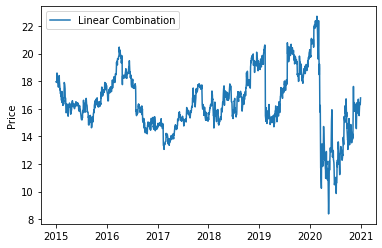

In [108]:
df_train['lc'] = -0.2566 * df_pep['Close'] + df_ko['Close']
plt.plot(df_train.index, df_train['lc'].values)
plt.ylabel('Price')
plt.legend(['Linear Combination']);

In [109]:
check_for_stationarity(df_train['lc'])

p-value = 0.008257191807387305 The series lc is likely stationary.


True

ABGOF and FSLR is a pair of stocks used in the tutorial and it **works**!

In [110]:
import pandas_datareader.data as web
import datetime as dt

df_abgb = web.DataReader('ABGOF', 'yahoo', dt.date(2014, 1, 1), dt.date(2015, 1, 1))
df_fslr = web.DataReader('FSLR', 'yahoo', dt.date(2014, 1, 1), dt.date(2015, 1, 1))
df_abgb

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-12-31,3.268293,3.268293,3.268293,3.268293,0.0,3.080742
2014-01-02,3.268293,3.268293,3.268293,3.268293,0.0,3.080742
2014-01-03,3.209756,3.209756,3.209756,3.209756,205.0,3.025564
2014-01-06,3.209756,3.209756,3.209756,3.209756,0.0,3.025564
2014-01-07,3.209756,3.209756,3.209756,3.209756,0.0,3.025564
...,...,...,...,...,...,...
2014-12-24,2.930000,2.930000,2.930000,2.930000,0.0,2.838344
2014-12-26,2.750000,2.750000,2.750000,2.750000,300.0,2.663974
2014-12-29,2.640000,2.570000,2.570000,2.640000,200.0,2.557415


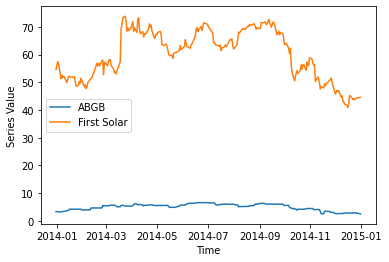

In [111]:
plt.plot(df_abgb['Close'])
plt.plot(df_fslr['Close'])
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['ABGB', 'First Solar'])
plt.show()

We may do the dirty work ourselves

In [112]:
import statsmodels.formula.api as smf

df_train2 = pd.DataFrame()
df_train2['X'] = df_abgb['Close']
df_train2['y'] = df_fslr['Close']
model = smf.ols(formula = 'y ~ X',
                data = df_train2).fit()
# This formula is given as domain knowledge
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     812.0
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.23e-80
Time:                        17:36:18   Log-Likelihood:                -725.53
No. Observations:                 253   AIC:                             1455.
Df Residuals:                     251   BIC:                             1462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.2121      1.187     22.927      0.000      24.875      29.550
X              6.6780      0.234     28.495      0.000       6.216       7.140
==============================================================================
Omnibus:                        1.042   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.594   Jarque-Bera (JB):                1.152
Skew:                           0.132   Prob(JB):                        0.562
Kurtosis:                       2.801   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

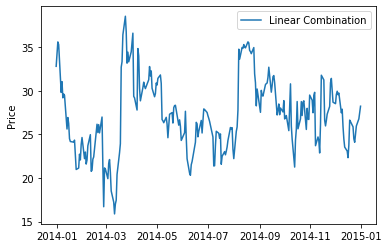

In [113]:
df_train2['lc'] = -6.6780 * df_abgb['Close'] + df_fslr['Close']
plt.plot(df_train2.index, df_train2['lc'])
plt.ylabel('Price')
plt.legend(['Linear Combination']);

In [114]:
check_for_stationarity(df_train2['lc'])

p-value = 0.0014867247275556408 The series lc is likely stationary.


True

Or we may just call statsmodels!

In [115]:
from statsmodels.tsa.stattools import coint

coint_t, p_value, crit_value = coint(df_abgb['Close'], df_fslr['Close'])
p_value

0.00995524258684153